In [1]:
import sys
sys.path.append('../')
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import algorithms.areamanager
%matplotlib inline


# Categories analysis

In [4]:
df_categories=pd.read_json("../data/categories.json")

# dicionário alias title 2 way
dict_alias_title=dict()
for index, row in df_categories.iterrows():
    dict_alias_title[row['alias']]=row['title']
    dict_alias_title[row['title']]=row['alias']


category_tree= nx.DiGraph()
for index, row in df_categories.iterrows():
    if not row['parents']:
        category_tree.add_edge(row['alias'],'root') # root node if no parents
    else:
        for parent_label in row['parents']:
            category_tree.add_edge(row['alias'],parent_label)

undirected_category_tree=category_tree.to_undirected()
# dict alias depth
dict_alias_depth=dict()
for index, row in df_categories.iterrows():
    dict_alias_depth[row['alias']]=nx.shortest_path_length(category_tree,row['alias'],'root')
dict_alias_depth['root']=0
df_categories=None

In [5]:
print("Número de categorias sem filtragem:",len(category_tree))

Número de categorias sem filtragem: 1566


In [6]:
count_nodes_in_depth=[0,0,0,0,0]
for category in category_tree.nodes:
    if count_nodes_in_depth[dict_alias_depth[category]] is None:
        count_nodes_in_depth[dict_alias_depth[category]]
    else:
        count_nodes_in_depth[dict_alias_depth[category]]=count_nodes_in_depth[dict_alias_depth[category]]+1
count_nodes_in_depth

[1, 22, 997, 527, 19]

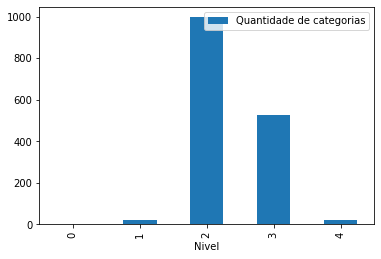

In [20]:
df=pd.DataFrame(count_nodes_in_depth,columns=['Quantidade de categorias'])
df.index.names=['Nivel']
df.plot(kind='bar')

In [23]:
df

,Quantidade de categorias
Nivel,
0,1
1,22
2,997
3,527
4,19


# Review and tip dataset 

In [2]:
columns=[('general','users'),
         ('general','pois'),
         ('general','checkins'),
         ('general','categories'),
         ('general','subareas'),
         ('general','pois/users'),
         ('general','checkins/users'),
         ('general','checkins/pois'),
         ('general','pois/subareas'),
         ('user_diff_checkins','mean'),
         ('user_diff_checkins','std'),
         ('user_diff_checkins','25%'),
         ('user_diff_checkins','50%'),
         ('user_diff_checkins','75%'),
         ('user_checkins','mean'),
         ('user_checkins','std'),
         ('user_checkins','25%'),
         ('user_checkins','50%'),
         ('user_checkins','75%'),
         ('subareas_poi','count'),
         ('subareas_poi','mean'),
         ('subareas_poi','std'),
         ('subareas_poi','25%'),
         ('subareas_poi','50%'),
         ('subareas_poi','75%'),
         ('subareas_checkin','count'),
         ('subareas_checkin','mean'),
         ('subareas_checkin','std'),
         ('subareas_checkin','25%'),
         ('subareas_checkin','50%'),
         ('subareas_checkin','75%')]

df_city_info=pd.DataFrame(columns=pd.MultiIndex.from_tuples(columns))
df_city_info.index.name="city"


In [3]:
def string_to_array(string):
    if string == '':
        return list()
    return eval(string)
def cities_info_generator(city_name):
    df_city_checkin=pd.read_csv("../data/checkin/"+city_name+".csv",converters={'categories':string_to_array})
    df_city_checkin.head()
    df_city_poi=pd.read_csv("../data/poi/"+city_name+".csv",converters={'categories':string_to_array})
    df_city_poi.head()
    # number of users
    users=df_city_checkin['user_id'].nunique()
    # number of pois
    pois=df_city_poi['business_id'].count()
    # number of check-ins
    checkins=df_city_checkin['date'].count()
    # number of categories
    categories_in_city=set()
    df_city_checkin.apply(lambda checkin: categories_in_city.update(checkin['categories']),axis=1)
    categories=len(categories_in_city)

    subareas=df_city_poi['subarea_id'].nunique()
    pois_per_users=pois/users
    checkins_per_users=checkins/users
    checkins_per_pois=checkins/pois
    poi_per_subarea=pois/subareas

    # diff pois visited, mean of diff pois visited of users
    user_diff_checkins=df_city_checkin[['user_id','business_id','date']].groupby(['user_id','business_id']).count().groupby('user_id').count()['date'].describe()
    # number check-ins of a user, mean of users check-ins on pois
    user_checkins=df_city_checkin[['user_id','business_id','date']].groupby(['user_id','business_id']).count().groupby('user_id').sum()['date'].describe()

    # subareas poi
    subareas_poi=df_city_poi[['subarea_id','business_id']].groupby('subarea_id').count().describe()['business_id']
    subareas_checkin=df_city_checkin[['subarea_id','user_id']].groupby('subarea_id').count().describe()['user_id']
    p=df_city_poi[['subarea_id','business_id']].groupby('subarea_id').count().sort_values(by='business_id',ascending=False).reset_index(drop=True).reset_index().plot.scatter(
        x=0,y="business_id")
    p.set_ylabel("Número de POIs")
    p.set_xlabel("ID subárea")

    p=df_city_checkin[['subarea_id','user_id']].groupby('subarea_id').count().sort_values(by='user_id',ascending=False).reset_index(drop=True).reset_index().plot.scatter(x=0,y="user_id")
    p.set_ylabel("Número de check-ins")
    p.set_xlabel("ID subárea")

    df_city_info.loc[city_name]= [users,pois,checkins,categories,subareas,
                                pois_per_users,checkins_per_users,checkins_per_pois,poi_per_subarea,
                                user_diff_checkins['mean'],
                                user_diff_checkins['std'],
                                user_diff_checkins['25%'],
                                user_diff_checkins['50%'],
                                user_diff_checkins['75%'],
                                user_checkins['mean'],user_checkins['std'],
                                user_checkins['25%'],user_checkins['50%'],
                                user_checkins['75%'],
                                subareas_poi['count'],
                                subareas_poi['mean'],
                                subareas_poi['std'],
                                subareas_poi['25%'],
                                subareas_poi['50%'],
                                subareas_poi['75%'],
                                subareas_checkin['count'],
                                subareas_checkin['mean'],
                                subareas_checkin['std'],
                                subareas_checkin['25%'],
                                subareas_checkin['50%'],
                                subareas_checkin['75%']]


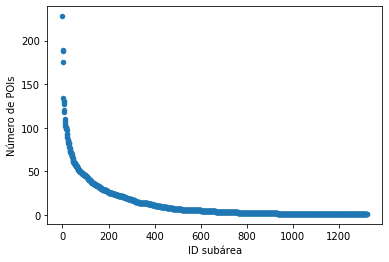

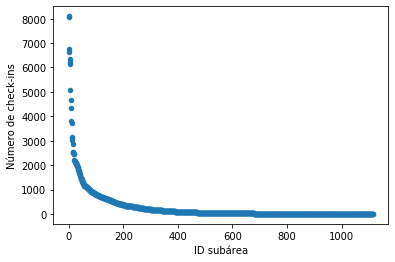

In [4]:
cities_info_generator("lasvegas")

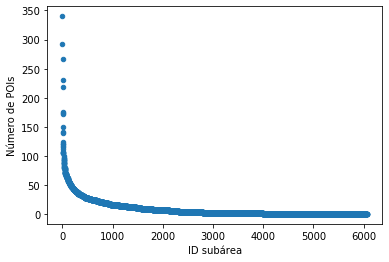

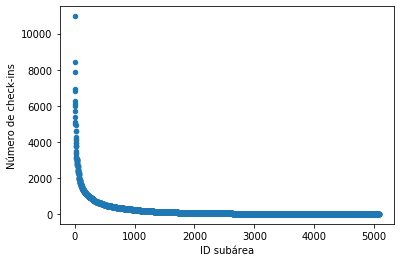

In [5]:
cities_info_generator("phoenix")

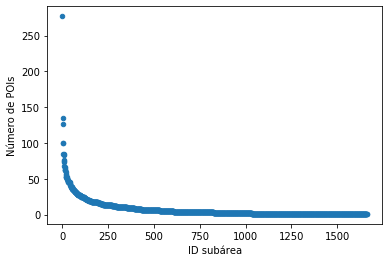

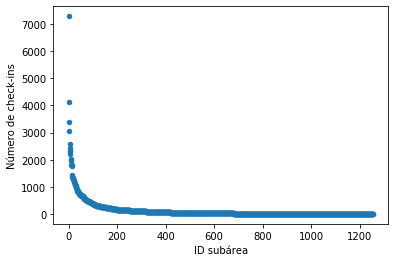

In [6]:
cities_info_generator("charlotte")

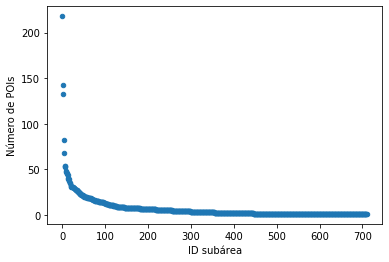

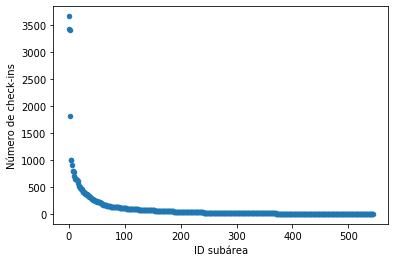

In [7]:
cities_info_generator("madison")

In [8]:
df_city_info

general                                                    \
             users     pois  checkins categories subareas pois/users   
city                                                                   
lasvegas    6189.0  17011.0  311191.0     1013.0   1322.0   2.748586   
phoenix    18507.0  56712.0  990314.0     1141.0   6066.0   3.064354   
charlotte   2721.0  12100.0  159879.0      864.0   1663.0   4.446895   
madison     1022.0   4815.0   52763.0      678.0    711.0   4.711350   

                                                     user_diff_checkins  ...  \
          checkins/users checkins/pois pois/subareas               mean  ...   
city                                                                     ...   
lasvegas       50.281306     18.293516     12.867625          39.555825  ...   
phoenix        53.510239     17.462160      9.349159          44.916680  ...   
charlotte      58.757442     13.213140      7.276007          49.356487  ...   
madison        51.627202     10.958048      6.772152          44.302348  ...   

          subareas_poi                 subareas_checkin              \
                   std  25%  50%   75%            count        mean   
city                                                                  
lasvegas     21.936041  1.0  4.0  15.0           1115.0  279.095067   
phoenix      16.527987  1.0  3.0  11.0           5087.0  194.675447   
charlotte    13.657366  1.0  2.0   8.0           1256.0  127.292197   
madison      13.940471  1.0  2.0   7.0            545.0   96.812844   

                                         
                  std  25%   50%    75%  
city                                     
lasvegas   739.281447  7.0  35.0  217.0  
phoenix    532.287609  6.0  28.0  146.0  
charlotte  378.609866  5.0  20.0   93.0  
madison    300.596548  6.0  20.0   75.0  

[4 rows x 31 columns]

,Usuários,POIs,Check-ins
city,,,
lasvegas,6189.0,17011.0,311191.0
phoenix,18507.0,56712.0,990314.0
charlotte,2721.0,12100.0,159879.0
madison,1022.0,4815.0,52763.0


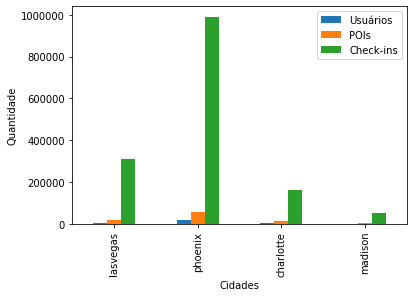

In [98]:
df_tmp=df_city_info.copy()
df_tmp=df_tmp[[('general','users'),('general','pois'),('general','checkins')]]
df_tmp.columns=df_tmp.columns.droplevel()
df_tmp.rename(columns={'users':'Usuários','pois':'POIs','checkins':'Check-ins'},inplace=True)
p=df_tmp.plot.bar()
p.set_xlabel("Cidades")
p.set_ylabel("Quantidade")
df_tmp

,Usuários,POIs
city,,
lasvegas,6189.0,17011.0
phoenix,18507.0,56712.0
charlotte,2721.0,12100.0
madison,1022.0,4815.0


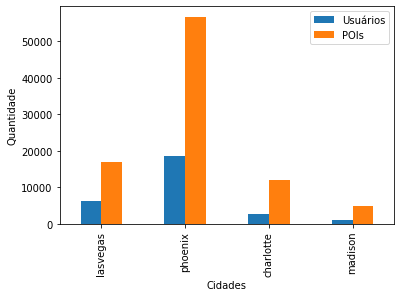

In [11]:
df_tmp=df_city_info.copy()
df_tmp=df_tmp[[('general','users'),('general','pois')]]
df_tmp.columns=df_tmp.columns.droplevel()
df_tmp.rename(columns={'users':'Usuários','pois':'POIs'},inplace=True)
p=df_tmp.plot.bar()
p.set_xlabel("Cidades")
p.set_ylabel("Quantidade")
df_tmp

,Categorias,Subáreas
city,,
lasvegas,1013.0,1322.0
phoenix,1141.0,6066.0
charlotte,864.0,1663.0
madison,678.0,711.0


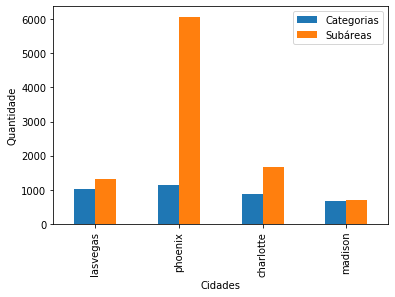

In [99]:
df_tmp=df_city_info.copy()
df_tmp=df_tmp[[('general','categories'),('general','subareas')]]
df_tmp.columns=df_tmp.columns.droplevel()
df_tmp.rename(columns={'categories':'Categorias','subareas':'Subáreas'},inplace=True)
p=df_tmp.plot.bar()
p.set_xlabel("Cidades")
p.set_ylabel("Quantidade")
df_tmp


,POIs/Usuários,Check-ins/Usuários,Check-ins/POIs,POIs/Subáreas
city,,,,
lasvegas,2.748586,50.281306,18.293516,12.867625
phoenix,3.064354,53.510239,17.462160,9.349159
charlotte,4.446895,58.757442,13.213140,7.276007
madison,4.711350,51.627202,10.958048,6.772152


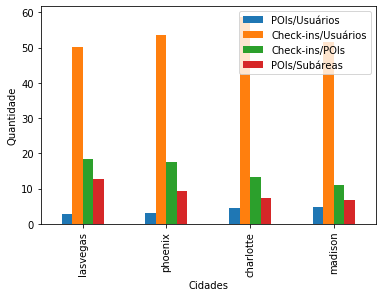

In [102]:
df_tmp=df_city_info.copy()
df_tmp=df_tmp[[('general','pois/users'),('general','checkins/users'),('general','checkins/pois'),('general','pois/subareas')]]
df_tmp.columns=df_tmp.columns.droplevel()
df_tmp.rename(columns={'pois/users':'POIs/Usuários','checkins/users':'Check-ins/Usuários','checkins/pois':'Check-ins/POIs','pois/subareas':'POIs/Subáreas'},inplace=True)
p=df_tmp.plot.bar()
p.set_xlabel("Cidades")
p.set_ylabel("Quantidade")
df_tmp


,Check-ins únicos,Check-ins
city,,
lasvegas,39.555825,50.281306
phoenix,44.916680,53.510239
charlotte,49.356487,58.757442
madison,44.302348,51.627202


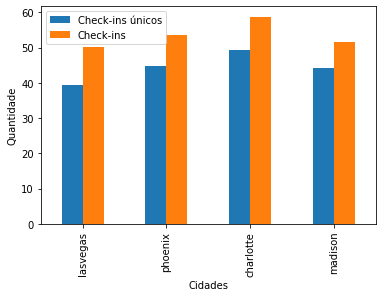

In [113]:
df_tmp=df_city_info.copy()
df_tmp=df_tmp[[
    ('user_diff_checkins','mean'),
    ('user_checkins','mean')]]
df_tmp.columns=df_tmp.columns.droplevel()
df_tmp.columns=[0,1]
df_tmp.rename(columns={0:'Check-ins únicos',1:'Check-ins'},inplace=True)
p=df_tmp.plot.bar()
p.set_xlabel("Cidades")
p.set_ylabel("Quantidade")
df_tmp


,Média de POIs nas subáreas,Desvio padrão de POIs nas subáreas
city,,
lasvegas,12.867625,21.936041
phoenix,9.349159,16.527987
charlotte,7.276007,13.657366
madison,6.772152,13.940471


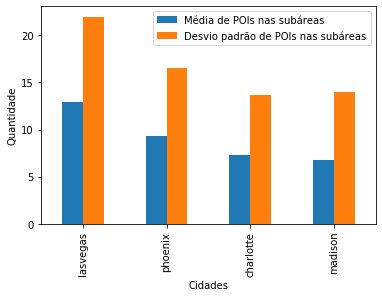

In [120]:
df_tmp=df_city_info.copy()
df_tmp=df_tmp[[
    ('subareas_poi','mean'),
    ('subareas_poi','std')]]
df_tmp.columns=df_tmp.columns.droplevel()
df_tmp.columns=[0,1]
df_tmp.rename(columns={0:'Média de POIs nas subáreas',1:'Desvio padrão de POIs nas subáreas'},inplace=True)
p=df_tmp.plot.bar()
p.set_xlabel("Cidades")
p.set_ylabel("Quantidade")
df_tmp


,Média de check-ins nas subáreas,Desvio padrão de check-ins nas subáreas
city,,
lasvegas,279.095067,739.281447
phoenix,194.675447,532.287609
charlotte,127.292197,378.609866
madison,96.812844,300.596548


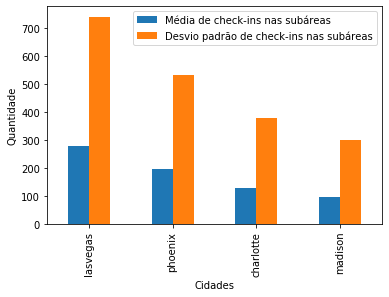

In [15]:
df_tmp=df_city_info.copy()
df_tmp=df_tmp[[
    ('subareas_checkin','mean'),
    ('subareas_checkin','std')]]
df_tmp.columns=df_tmp.columns.droplevel()
df_tmp.columns=[0,1]
df_tmp.rename(columns={0:'Média de check-ins nas subáreas',1:'Desvio padrão de check-ins nas subáreas'},inplace=True)
p=df_tmp.plot.bar()
p.set_xlabel("Cidades")
p.set_ylabel("Quantidade")
df_tmp


,25%,50%,75%,std
city,,,,
lasvegas,24.0,32.0,51.0,65.443585
phoenix,24.0,32.0,53.0,73.494052
charlotte,24.0,33.0,59.0,81.424545
madison,24.0,33.0,57.0,53.835231


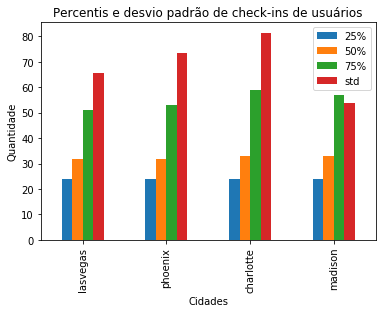

In [23]:
# porcentagem de subareas com pois
df_tmp=df_city_info.copy()
df_tmp=df_tmp[[
    ('user_checkins','25%'),
    ('user_checkins','50%'),
    ('user_checkins','75%'),
    ('user_checkins','std')
]]
df_tmp.columns=df_tmp.columns.droplevel()
p=df_tmp.plot.bar(title="Percentis e desvio padrão de check-ins de usuários")
p.set_xlabel("Cidades")
p.set_ylabel("Quantidade")
df_tmp


,25%,50%,75%,std
city,,,,
lasvegas,21.0,27.0,41.0,44.142893
phoenix,22.0,29.0,46.0,54.019896
charlotte,22.0,29.0,50.0,63.362758
madison,23.0,30.5,51.0,38.920064


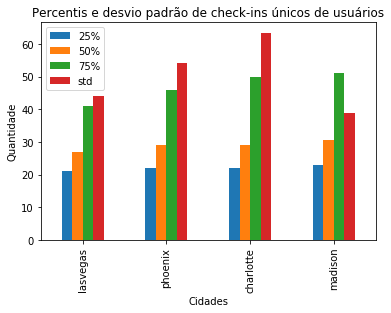

In [24]:
# porcentagem de subareas com pois
df_tmp=df_city_info.copy()
df_tmp=df_tmp[[
    ('user_diff_checkins','25%'),
    ('user_diff_checkins','50%'),
    ('user_diff_checkins','75%'),
    ('user_diff_checkins','std')
]]
df_tmp.columns=df_tmp.columns.droplevel()
p=df_tmp.plot.bar(title="Percentis e desvio padrão de check-ins únicos de usuários")
p.set_xlabel("Cidades")
p.set_ylabel("Quantidade")
df_tmp


,25%,50%,75%,std
city,,,,
lasvegas,1.0,4.0,15.0,21.936041
phoenix,1.0,3.0,11.0,16.527987
charlotte,1.0,2.0,8.0,13.657366
madison,1.0,2.0,7.0,13.940471


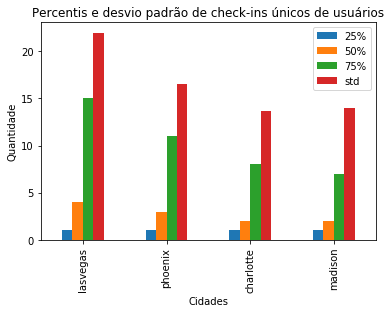

In [25]:
# porcentagem de subareas com pois
df_tmp=df_city_info.copy()
df_tmp=df_tmp[[
    ('subareas_poi','25%'),
    ('subareas_poi','50%'),
    ('subareas_poi','75%'),
    ('subareas_poi','std')
]]
df_tmp.columns=df_tmp.columns.droplevel()
p=df_tmp.plot.bar(title="Percentis e desvio padrão de POIs em subáreas")
p.set_xlabel("Cidades")
p.set_ylabel("Quantidade")
df_tmp


,25%,50%,75%,std
city,,,,
lasvegas,7.0,35.0,217.0,739.281447
phoenix,6.0,28.0,146.0,532.287609
charlotte,5.0,20.0,93.0,378.609866
madison,6.0,20.0,75.0,300.596548


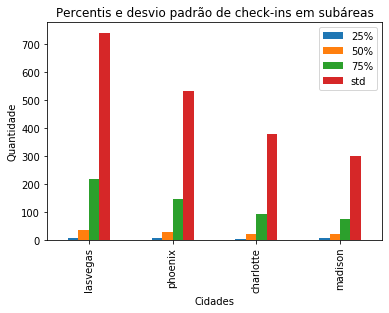

In [26]:
# porcentagem de subareas com pois
df_tmp=df_city_info.copy()
df_tmp=df_tmp[[
    ('subareas_checkin','25%'),
    ('subareas_checkin','50%'),
    ('subareas_checkin','75%'),
    ('subareas_checkin','std')
]]
df_tmp.columns=df_tmp.columns.droplevel()
p=df_tmp.plot.bar(title="Percentis e desvio padrão de check-ins em subáreas")
p.set_xlabel("Cidades")
p.set_ylabel("Quantidade")
df_tmp
